In [1]:
#Esto me sirve para el correcto funcionamiento de las funciones importadas en este notebook
%load_ext autoreload
%autoreload 2

# Modelado

Cargamos los conjuntos de datos y librerías que se usarán en esta sección:

In [ ]:
from utils.paths import crear_funcion_directorio
import pandas as pd

#Creo un acceso directo a la carpeta de data
data_dir = crear_funcion_directorio("data")

#Cargo los conjuntos de datos
X_train = pd.read_csv(data_dir("for_modeling", "X_train.csv"))
y_train = pd.read_csv(data_dir("for_modeling", "y_train.csv"))

## Preprocesamiento de datos

Hasta este punto, hemos creado un conjunto de datos para el proyecto, analizado los datos y descubierto patrones que pueden resultar valiosos al desarrollar el modelo final. El siguiente paso consiste en preparar estas variables de interés para su uso en el entrenamiento de nuestro modelo.

Primero procederemos a separar las variables en **X_train** (que contendrá las  candidatas a variables predictoras) y **y_train** (donde ubicaremos nuestra variable objetivo, **'mvp_share'**).

In [ ]:
X_train = df_data_jugadores_train.loc[:, correlated_features]
y_train = df_data_jugadores_train.loc[:, ['mvp_share']]

Comencemos por verificar si existen valores faltantes en **X_train**. Dado que ya hemos imputado el valor cero en toda la variable **y_train**, no es necesario hacer esta misma examinación en ella.

In [ ]:
#Guardo la suma de valores faltantes por columna
valores_faltantes = X_train.isnull().sum()

print(valores_faltantes)

Observamos que en nuestras variables de interés no contamos con valores faltantes, por lo tanto podemos proseguir con la estandarización de los datos:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Genero un pipeline
pip = Pipeline([
 ('std_scaler', StandardScaler())
 ])

#Aplico la transformación
X_train_prepared = pip.fit_transform(X_train)

## Generando el modelo

Ahora, llegamos a la etapa en la que comenzamos a modelar nuestros datos y explorar qué información relevante pueden proporcionarnos, lo que constituye el núcleo de nuestro proyecto. Nuestro criterio para determinar la idoneidad de un modelo se basa en su capacidad para minimizar el error en las predicciones y así poder ubicar de manera correcta a los jugadores que están en **el podio del premio**.

## Definición de funciones útiles

Antes de empezar con el proceso de entrenamiento de un modelo, decidimos generar algunas funciones que nos serán útiles para luego simplicar este proceso:

In [ ]:
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

#Defino una grilla de métricas para regresión
regression_scores = {'R^2 score' : 'r2',
                     'Explained Variance':'explained_variance',
                     'MSE':'neg_mean_squared_error',
                     'RMSE' : make_scorer(mean_squared_error, squared=False),
                     }

#Hago una función para la validación cruzada
def cross_validation_scores(model, X, y, scoring, CV):
    '''
    Métricas de validación cruzada

    param_model: modelo
    param_X: características
    param_y: etiqueta objetivo
    param_scoring: una selección de métricas
    param_CV: cantidad de divisiones para la validación cruzada
    '''

    # Instancio el objeto TimeSeriesSplit para dividir en series de tiempo
    tscv = TimeSeriesSplit(n_splits=CV)

    scores = cross_validate(model, X, y.values.ravel(), scoring=scoring, cv=tscv)

    #Obtengo el puntaje promedio y la desviación estandar de cada modelo
    return {metric: (round(np.mean(scores), 3)) for metric, scores in scores.items()}

def mostrar_podio_MVP(temporada:int, y_pred, df_base:pd.DataFrame, cant_jugadores:int):
    '''
    Esta función toma las predicciones generadas por el modelo
    en cuestión y retorna un dataframe de las mismas junto
    con el valor real por cada temporada y jugador.
    '''

    # Genero un dataframe donde guardo las predicciones y el valor real
    df_comp = df_base[['season', 'player', 'mvp_share']]
    df_comp['y_pred'] = y_pred.flatten()
    df_comp = df_comp.sort_values(by='y_pred', ascending=False)

    return df_comp[df_comp['season'] == temporada].head(cant_jugadores)


## Random Forest

El modelo que hemos decidido utilizar es el **Random Forest**. Según nuestro criterio, este modelo es adecuado para evitar el **sobreajuste** y tiene la capacidad de generalizar bien con los datos disponibles. Además, es altamente útil para evaluar la **importancia** de cada atributo que utilizamos en el proceso de entrenamiento. Esto, a su vez, nos proporciona una comprensión más profunda de **cómo opera el premio** y los factores que influyen en él.

Emplearemos **RandomizedSearchCV** para encontrar la combinación óptima de hiperparámetros para nuestro modelo. Hemos elegido una grilla de hiperparámetros extensa con el fin de garantizar una búsqueda precisa y obtener una comprensión sólida de nuestros requisitos.

In [ ]:
#Instancio el modelo
forest_reg = RandomForestRegressor()

#Preparo la grilla de hipérparametros
param_grid = {
    'n_estimators': list(range(1, 1000)),
    'max_features': ['auto', 'sqrt'],
    'max_depth': list(range(1, 500)),
    'bootstrap': [True, False],
    'criterion': ['friedman_mse', 'absolute_error', 'poisson', 'squared_error'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

#Instancio de vuelta otro objeto tscv para mantener el orden con el tiempo
tscv = TimeSeriesSplit(n_splits=3)

#Hago la búsqueda de hiperparámetros
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_grid, n_iter=100, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
random_search.fit(X_train_prepared, y_train)

#Miro los mejores hipérparametros
best_params = random_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

Ahora que realizamos este procedimiento, **guardaremos los hiperparámetros** obtenidos en nuestro modelo Random Forest para luego utilizar el mismo:

In [ ]:
forest_reg_best = RandomForestRegressor(
    random_state=42,
    n_estimators=566,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=254,
    criterion='poisson',
    bootstrap=True
)
forest_reg_best.fit(X_train_prepared, y_train)
y_train_pred = forest_reg_best.predict(X_train_prepared)

Ahora con este modelo, usaremos las funciones definidas anteriormente para evaluar su desempeño:

In [ ]:
#Uso función de validación cruzada
print("Métricas usando validación cruzada:")
print(cross_validation_scores(forest_reg_best, X_train_prepared, y_train, regression_scores, 2))
print()
#Ahora evaluo las mismas métricas pero en el dataset de Train completo
r2_train = r2_score(y_train, y_train_pred)
explained_variance_train = explained_variance_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print("Métricas en el conjunto de entrenamiento:")
print(f"Coeficiente de determinación (R²): {r2_train:.4f}")
print(f"Varianza explicada: {explained_variance_train:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse_train:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_train:.4f}")

Observamos una diferencia notable en el rendimiento del modelo al utilizar la validación cruzada en comparación con la evaluación directa en el conjunto de datos de entrenamiento. Este contraste podría deberse a la variabilidad introducida por la validación cruzada, que refleja cómo el modelo generaliza en diferentes conjuntos de datos de prueba durante cada iteración del proceso de validación cruzada. Por otro lado, la evaluación en el conjunto de entrenamiento se realiza en datos con los que el modelo ya ha sido entrenado, lo que puede llevar a una representación más optimista del rendimiento. La diferencia en el R², la Varianza Explicada y otras métricas puede indicar cómo el modelo se desempeña en datos nuevos frente a datos ya conocidos durante el entrenamiento. Es crucial tener en cuenta esta diferencia al realizar evaluaciones futuras de nuestro modelo, esto ya nos dá una fuerte idea de como se podría comportar a futuro.

Ahora procedemos a realizar un análisis gráfico del modelo, representando gráficamente los valores reales de la variable objetivo **'mvp_share'** frente a los valores predichos por nuestro modelo:

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.regplot(x=y_train_pred, y=y_train, scatter_kws={'color': '#1f77b4'}, line_kws={'color': 'black', 'linewidth': 2})
plt.xlabel('y_train (Valores Reales)')
plt.ylabel('y_train_pred (Predicciones)')
plt.title('Comparación: Valores de datos de entrenamiento vs Predicción del modelo', fontsize=14)

Gráficamente, evidenciamos que nuestro modelo se ajusta de **manera precisa** a los datos de entrenamiento, como habíamos observado al analizar las métricas. Además, **el ajuste no es excesivamente pronunciado**, indicando que el modelo no sobreajusta nuestros datos. Esta observación es satisfactoria, ya que sugiere que estamos frente a un modelo aceptable.

Como conclusión, emplearemos otra de las funciones previamente definidas para visualizar cómo posiciona nuestro modelo a los jugadores en la votación. Esta métrica es crucial, ya que nuestro objetivo principal era desarrollar un modelo que minimizara el error al posicionar correctamente a los jugadores. Una vez logrado este objetivo, podemos realizar un análisis más preciso del premio. A continuación, presentamos algunas temporadas anteriores para evaluar el rendimiento de nuestro modelo:

In [ ]:
mostrar_podio_MVP(temporada = 2011, y_pred = y_train_pred, df_base = df_data_jugadores_train, cant_jugadores= 5)

In [ ]:
mostrar_podio_MVP(temporada = 2014, y_pred = y_train_pred, df_base = df_data_jugadores_train, cant_jugadores= 5)

In [ ]:
mostrar_podio_MVP(temporada = 2016, y_pred = y_train_pred, df_base = df_data_jugadores_train, cant_jugadores= 5)

In [ ]:
mostrar_podio_MVP(temporada = 2017, y_pred = y_train_pred, df_base = df_data_jugadores_train, cant_jugadores= 5)

Podemos notar que, aunque existe una diferencia entre los valores de **'mvp_share'** y **'y_pred'**, nuestro modelo **logró ordenar de manera efectiva** a los jugadores, identificando correctamente a los ganadores de los años seleccionados. Sin embargo, es crucial recordar que estamos utilizando **datos de entrenamiento** y la verdadera prueba se llevará a cabo en los datos reservados para pruebas. A continuación, proporcionamos una lista de los últimos ganadores del premio para que puedan verificar la precisión de nuestro modelo:

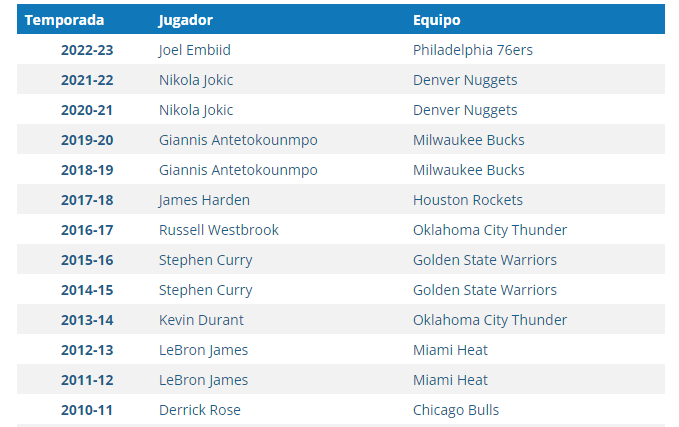

Ahora que contamos con un modelo que **consideramos aceptable** y ha demostrado un buen rendimiento en los datos de entrenamiento, tanto en métricas como en su capacidad para **posicionar correctamente a los jugadores**, avanzamos hacia la **fase final**. En esta etapa, pondremos a prueba el mismo modelo con los datos de prueba y posteriormente extraeremos nuestras conclusiones al respecto.